In [1]:
import math
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from calibration import *
from laneFinder import LaneFinder
from thresholder import Thresholder
from pipeline import PipeLine
from moviepy.editor import VideoFileClip

%load_ext autoreload
%autoreload 2

%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg


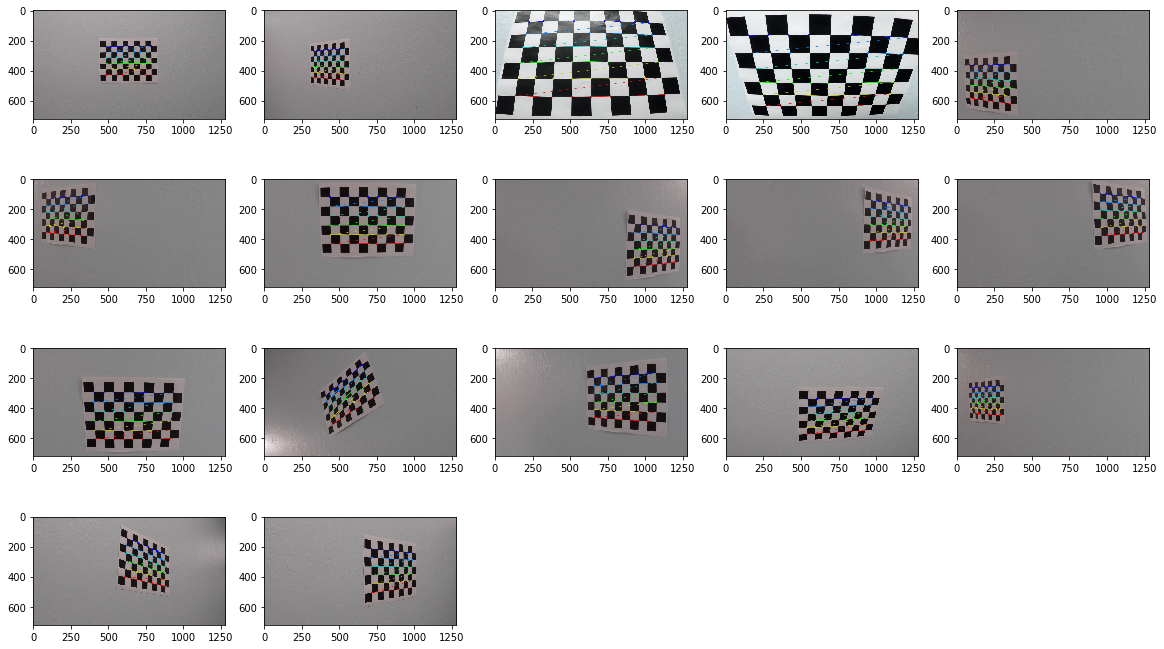

In [14]:
# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 15)

sizeBoardCorners = (9, 6)
ret, mtx, dist = calDistortMatrix('camera_cal', sizeBoardCorners, ifPlot=True)

### Apply the distortion correction to one of the calibration image:

Text(0.5,1,'Undistorted Image')

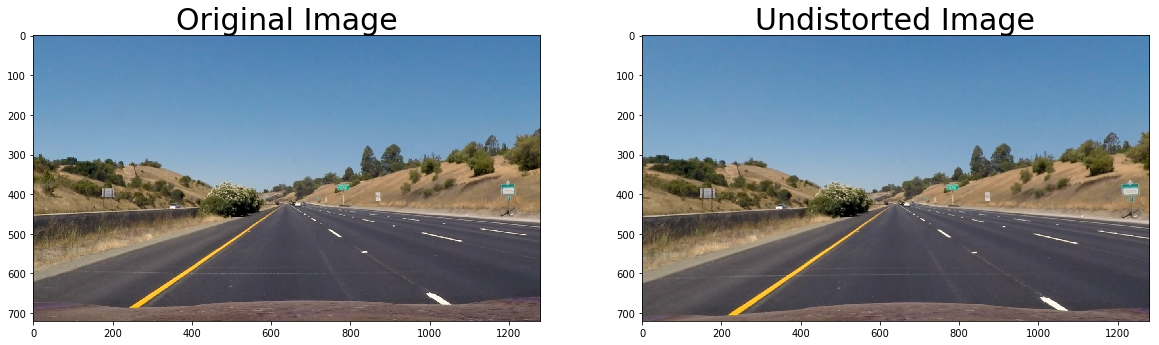

In [19]:
fn = 'test_images/straight_lines1.jpg'
img = cv2.imread(fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image
Define all kinds of masking functions first.

Test the masking over testing images

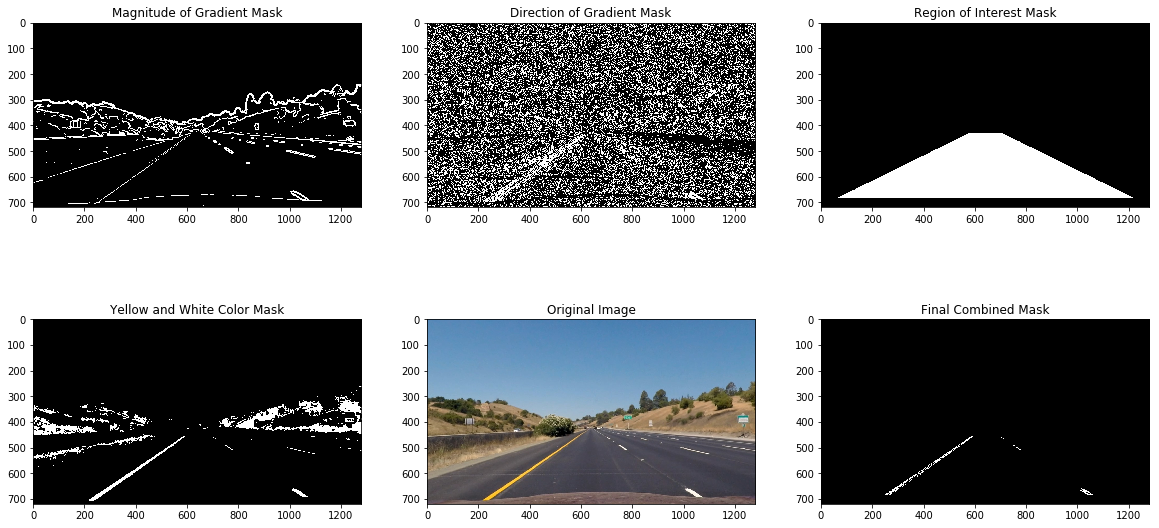

In [20]:
# ------------------------------------
imgTest = img_corrected
thObj = Thresholder()

sobelx, sobely = thObj.get_gradient(imgTest)

gradmagMask = thObj.mag_thresh(sobelx, sobely)
graddirMask = thObj.dir_thresh(sobelx, sobely)
roiMask = thObj.roi_thresh(imgTest)
colorMask = thObj.color_thresh(imgTest)
combinedMask = thObj.threshold(imgTest)

# Display
f, axhandles = plt.subplots(2, 3, figsize=(20,10))

axhandles[0, 0].imshow(gradmagMask*255, cmap='gray')
axhandles[0, 0].set_title('Magnitude of Gradient Mask')
axhandles[0, 1].imshow(graddirMask*255, cmap='gray')
axhandles[0, 1].set_title('Direction of Gradient Mask')
axhandles[0, 2].imshow(roiMask*255, cmap='gray')
axhandles[0, 2].set_title('Region of Interest Mask')
    
axhandles[1, 0].imshow(colorMask, cmap='gray')
axhandles[1, 0].set_title('Yellow and White Color Mask')
axhandles[1, 1].imshow(imgTest)
axhandles[1, 1].set_title('Original Image')
axhandles[1, 2].imshow(combinedMask, cmap='gray')
axhandles[1, 2].set_title('Final Combined Mask')

plt.show()

### Apply a perspective transform to rectify binary image ("birds-eye view").

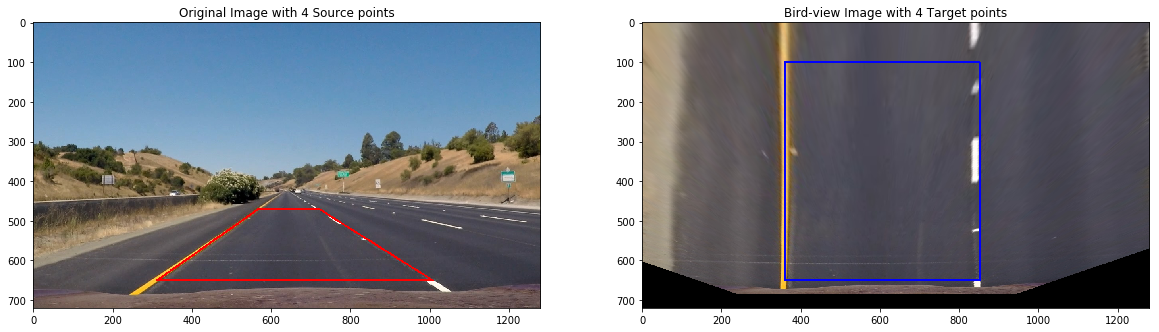

In [21]:
%autoreload 2

# define 4 points over a rectangular region within the lane in both the original view and the target (bird) view
M, M_inv = computePerspective(ifPlot=True)

Text(0.5,1,' Bird-view Combined Mask')

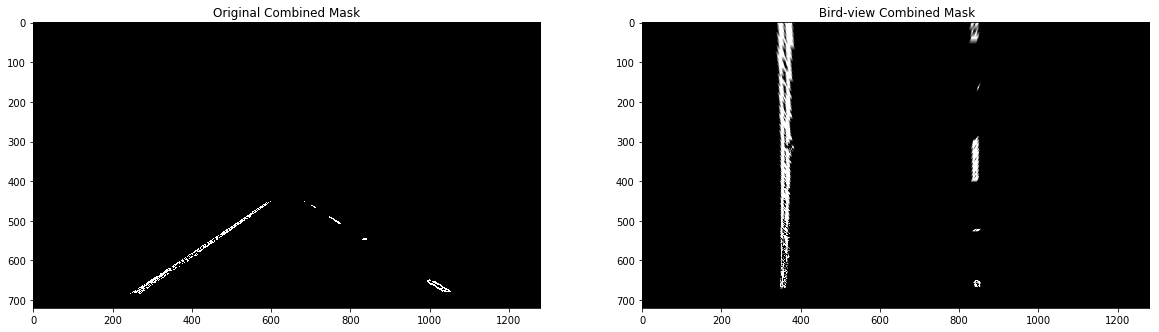

In [6]:

# get mask and the bird-view of it
mask_orig = combinedMask
mask_bird = cv2.warpPerspective(np.float64(mask_orig), M, (mask_orig.shape[1], mask_orig.shape[0]), flags=cv2.INTER_LINEAR)

# Display
f, axhandles = plt.subplots(1,2, figsize=(20,10))

axhandles[0].imshow(mask_orig, cmap = 'gray')
axhandles[0].set_title('Original Combined Mask')

axhandles[1].imshow(mask_bird, cmap = 'gray')
axhandles[1].set_title(' Bird-view Combined Mask')

### Detect lane pixels and fit to find the lane boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initial Lane Centers: left = 352, right = 841


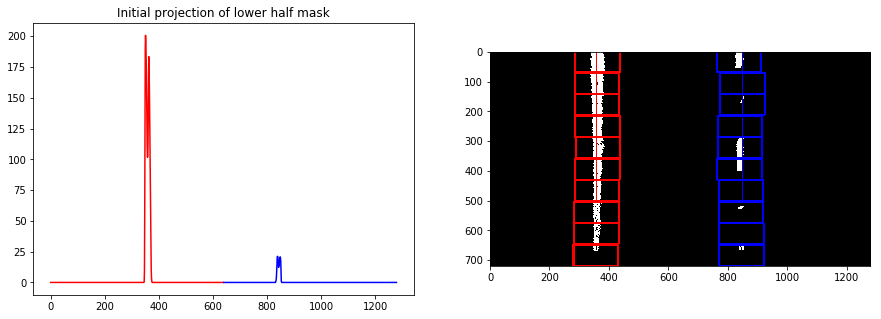

In [23]:
%autoreload 2

plt.rcParams['figure.figsize'] = (15, 5)

# m = np.copy(mask_bird)
laneFinderObj = LaneFinder(M, M_inv)
outimg = laneFinderObj.run(imgTest, mask_bird)

# Display
proj = laneFinderObj.init_proj
halfLen = int(len(proj)/2)
rng1 = range(halfLen)
rng2 = range(halfLen, 2*halfLen)

plt.subplot(1,2,1)
plt.plot(rng1, proj[rng1], 'r', rng2, proj[rng2], 'b')
plt.title('Initial projection of lower half mask')
plt.subplot(1,2,2)
plt.imshow(laneFinderObj.mask_laneAndWindow)
plt.show()

### Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
car_position = laneFinderObj.c_shift_cm
print("Car location {:.3f} cm off center. ".format(car_position))


Car location 6.638 cm off center. 


### Warp the detected lane boundaries back onto the original image. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


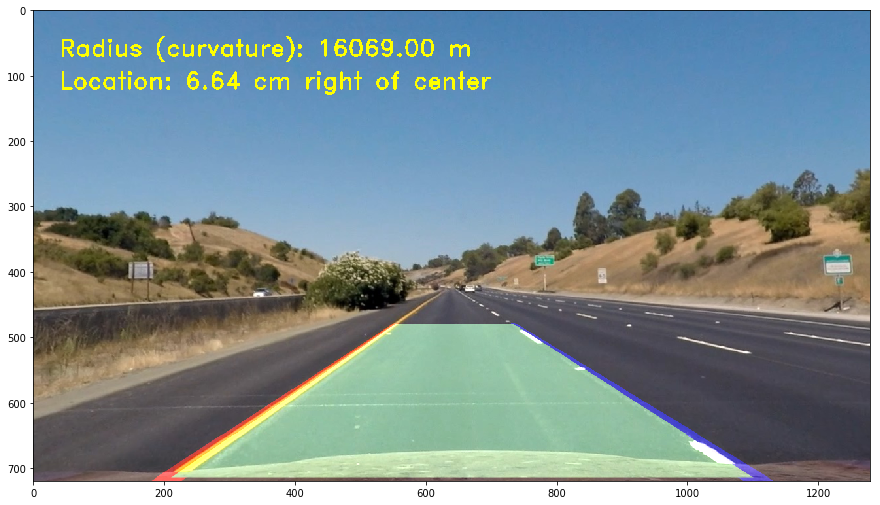

In [25]:
output_origView = laneFinderObj.final

# Display
plt.rcParams['figure.figsize'] = (15, 15)

plt.imshow(output_origView)
plt.show()

### Re-run the whole pipeline over a single image

Pipeline Initialization: Calculating lens distortion ...
failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg
Pipeline Initialization: Calculating bird view transform matrix ...
Pipeline Initialization: Initializing LaneFinder instance ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initial Lane Centers: left = 352, right = 836


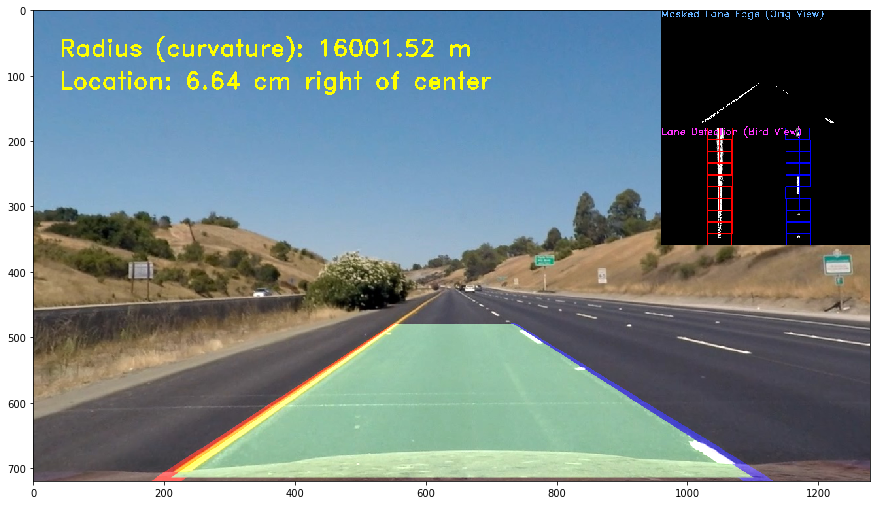

In [22]:
%autoreload 2

img = img_corrected

p = PipeLine()
res = p.run_Pipeline(img)

# Display
plt.rcParams['figure.figsize'] = (15, 15)

plt.imshow(res)
plt.show()

In [11]:
## Run the pipeline over the entire video

In [13]:
%autoreload 2

input_fn = 'videos/project_video.mp4'
tmp = input_fn.split('.')
tmp[0] += '_output'
output_fn = '.'.join(tmp)

p = PipeLine()

video_input1 = VideoFileClip(input_fn)#.subclip(35, 42)
processed_video = video_input1.fl_image(p.run_Pipeline)

%time processed_video.write_videofile(output_fn, audio=False)


Pipeline Initialization: Calculating lens distortion ...
failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg
Pipeline Initialization: Calculating bird view transform matrix ...
Pipeline Initialization: Initializing LaneFinder instance ...
Initial Lane Centers: left = 394, right = 884
[MoviePy] >>>> Building video videos/project_video_output.mp4
[MoviePy] Writing video videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:21<00:00,  3.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_output.mp4 

CPU times: user 7min 13s, sys: 1min 31s, total: 8min 44s
Wall time: 6min 21s
